In [1]:
import xarray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pycountry

from climada.entity import Exposures
import climada.util.coordinates as u_coord
from climada_petals.engine import SupplyChain

import logging

LOGGER = logging.getLogger()

This notebook shows how to load various geo data as CLIMADA exposure. The geo data represents proxies exposures of the manufacturing, mining, forestry, and agricultural sectors. For mining and forestry, no information regarding the value of the exposed assets is provided. For these cases, we use production values in the IOT tables to disaggregate exposed values.

In [2]:
def get_forestry_exp(
                    nc_file_path=None,
                    land_classes=None,
                    countries=None,
                    mriot_type='WIOD16',
                    mriot_year=2010,
                    repr_sectors='Forestry and logging',
                    apply_boundaries = False
                    ):
    """
    Get forestry exposure.

    nc_file_path : str
        local path to COPERNICUS netcdf file.
    land_classes : list of land classes
        land use classes of interest.
        For more info see on the meaning of land use classes
        https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-land-cover?tab=doc
    countries : list
        countries' ISO3
    mriot_type : str
    mriot_year : str
    apply_boundaries : bool
        If only points that actually end up in countries' polygon are selected.
        This makes sure there are no false positives, but substantially increases
        required computation. Default False
    """

    if (len(countries) > 0) | (len(land_classes) > 0):
        LOGGER.warning(
            "Either multiple countries or land use classes were selected. Mind that"
            " this may be too heavy to handle in many cases. If so, try loading individual"
            " countries and classes."
        )

    glob_prod, repr_sectors = get_prod_secs(mriot_type, mriot_year, repr_sectors)

    data = xarray.open_dataset(nc_file_path)

    cnt_dfs = []
    for iso3_cnt in countries:
        print(f'Country {iso3_cnt}')

        target_geometries = u_coord.get_land_geometry(iso3_cnt)
        min_lon, min_lat, max_lon, max_lat = target_geometries.bounds

        if iso3_cnt == 'USA':
            max_lon = -50

        elif iso3_cnt == 'RUS':
            min_lon = 35

        lat_sel = np.where((data.lat > min_lat) & (data.lat < max_lat))[0]
        lon_sel = np.where((data.lon > min_lon) & (data.lon < max_lon))[0]

        data_sel = data.isel(lon=lon_sel, lat=lat_sel, time=0)['lccs_class']

        cnt_df = data_sel.to_dataframe().drop(columns='time'
                ).reset_index().rename(columns = {'lat': 'latitude',
                                                  'lon': 'longitude'})

        lnd_dfs = []
        for lnd_cls in land_classes:
            print(f'Land class {lnd_cls}')

            lnd_df = cnt_df[cnt_df.lccs_class == lnd_cls]

            if apply_boundaries:
                lnd_df['geometry'] = gpd.points_from_xy(
                                x = lnd_df.longitude,
                                y = lnd_df.latitude
                                )
                within_geom = target_geometries.contains(lnd_df.geometry.values)
                lnd_df = lnd_df[within_geom]

            lnd_dfs.append(lnd_df)

        cnt_df = pd.concat(lnd_dfs).reset_index(drop=True)

        try:
            cnt_df['value'] = 1 / glob_prod.loc[iso3_cnt].loc[repr_sectors].sum().values[0]
        except KeyError:
            LOGGER.warning('You are simulating a country for which there are no production data in the chosen IOT')
            cnt_df['value'] = 1 / glob_prod.loc['ROW'].loc[repr_sectors].sum().values[0]

        cnt_dfs.append(cnt_df)

    exp = Exposures(pd.concat(cnt_dfs).reset_index(drop=True))
    exp.set_geometry_points()

    return exp



In [2]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

C:\Users\AndreaAngelidou\AppData\Local\Temp\ipykernel_4384\3744710904.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


# amended code

In [20]:
def get_forestry_exp_new(
                    countries=None,
                    mriot_type='WIOD16',
                    mriot_year=2010,
                    repr_sectors='Forestry and logging'):
    

    glob_prod, repr_sectors = get_prod_secs(mriot_type, mriot_year, repr_sectors)

    cnt_dfs = []

    data = pd.read_hdf("forest_exp_region_final.h5")

    for iso3_cnt in countries:
        
        cnt_df = data.loc[data['region_id'] == iso3_cnt]

        try:
            cnt_df['value'] = 1 / glob_prod.loc[iso3_cnt].loc[repr_sectors].sum().values[0]
        except KeyError:
            LOGGER.warning('You are simulating a country for which there are no production data in the chosen IOT')
            cnt_df['value'] = 1 / glob_prod.loc['ROW'].loc[repr_sectors].sum().values[0]
    
        cnt_dfs.append(cnt_df)

    exp = Exposures(pd.concat(cnt_dfs).reset_index(drop=True))
    exp.set_geometry_points()

    return exp

def get_prod_secs(mriot_type, mriot_year, repr_sectors):
    mriot = SupplyChain.from_mriot(mriot_type=mriot_type, 
                                mriot_year=mriot_year).mriot

    if isinstance(repr_sectors, (range, np.ndarray)):
        repr_sectors = mriot.get_sectors()[repr_sectors].tolist()

    elif isinstance(repr_sectors, str):
        repr_sectors = [repr_sectors]
    
    return mriot.x, repr_sectors

# Forestry

Data from: https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.006f2c9a?tab=overview. Registration needed. After download, unzip folder.

See extra docs https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-land-cover?tab=doc for land use classes codes.

In [21]:
# open data to get counties
data = pd.read_hdf("forest_exp_region_final.h5")
countries = data["region_id"].unique().tolist()
countries.sort()
del data

# apply function that alters the value using MRIO
exp = get_forestry_exp_new(
    countries=countries, 
    mriot_type='WIOD16',          
    mriot_year=2010,
    repr_sectors='Forestry and logging')

C:\Users\AndreaAngelidou\AppData\Local\Temp\ipykernel_4384\2392141304.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  cnt_df['value'] = 1 / glob_prod.loc[iso3_cnt].loc[repr_sectors].sum().values[0]
C:\Users\AndreaAngelidou\Documents\climada-workspace\climada-workspace\my_files\climada\util\coordinates.py:2749: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(


C:\Users\AndreaAngelidou\AppData\Local\Temp\ipykernel_4384\544187528.py:6: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  exp.gdf.plot(column='value', markersize=0.001, ax=ax, color='red')


<Axes: >

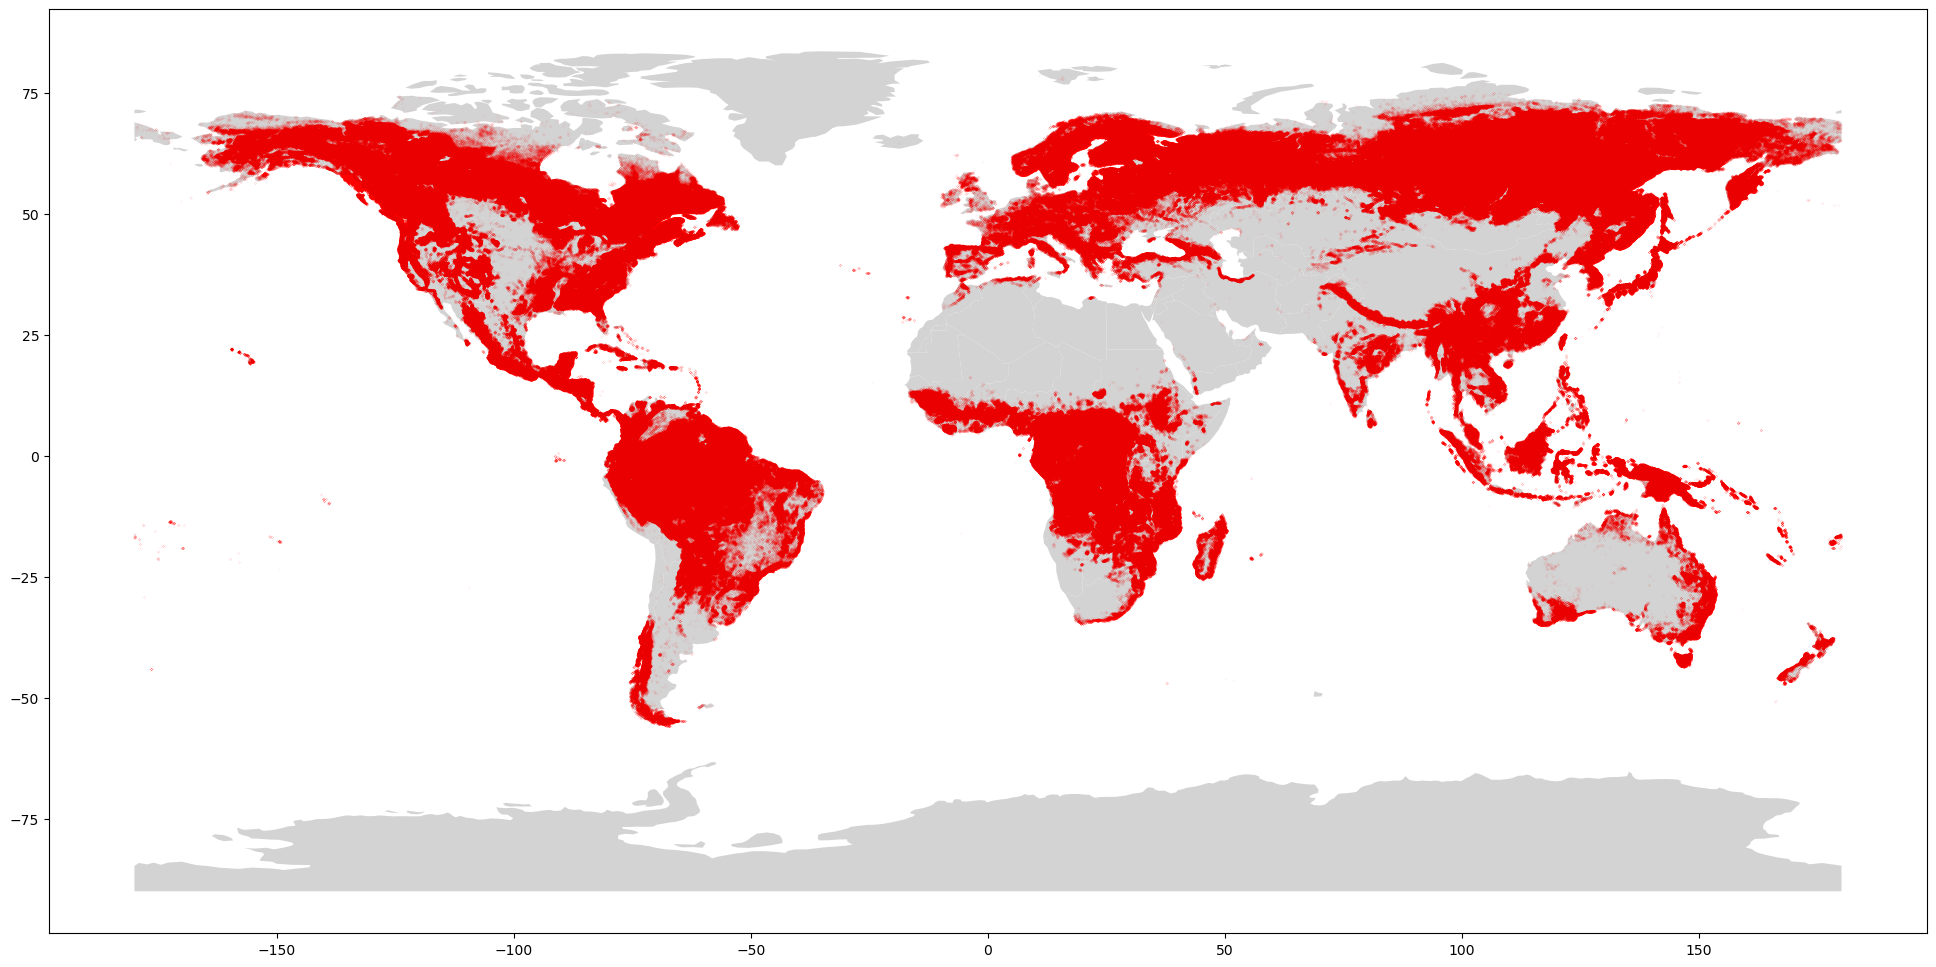

In [5]:
# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(30, 12))
worldmap.plot(color="lightgrey", ax=ax)

#rand_ind = np.random.choice(exp.gdf.index, 100000, replace=False)
exp.gdf.plot(column='value', markersize=0.001, ax=ax, color='red')

In [6]:
exp.gdf

,latitude,longitude,value,region_id,geometry
0,37.193056,67.751389,0.000013,AFG,POINT (67.75139 37.19306)
1,36.498611,70.001389,0.000013,AFG,POINT (70.00139 36.49861)
2,35.637500,71.306944,0.000013,AFG,POINT (71.30694 35.63750)
3,35.637500,71.334722,0.000013,AFG,POINT (71.33472 35.63750)
4,35.609722,71.334722,0.000013,AFG,POINT (71.33472 35.60972)
...,...,...,...,...,...
5771705,-22.334722,31.279167,0.000013,ZWE,POINT (31.27917 -22.33472)
5771706,-22.334722,31.306944,0.000013,ZWE,POINT (31.30694 -22.33472)
5771707,-22.334722,31.362500,0.000013,ZWE,POINT (31.36250 -22.33472)
5771708,-22.362500,31.334722,0.000013,ZWE,POINT (31.33472 -22.36250)


In [8]:
df = exp.gdf.drop(columns='geometry')

In [11]:
df.to_hdf("forestry_values_MRIO.h5", key="data", mode='w')

###### check value

In [22]:
exp.gdf.loc[exp.gdf['region_id'] == "USA"]

,latitude,longitude,value,region_id,geometry
5252502,71.304167,-156.720833,0.000034,USA,POINT (-156.72083 71.30417)
5252503,71.304167,-156.693056,0.000034,USA,POINT (-156.69306 71.30417)
5252504,71.165278,-156.637500,0.000034,USA,POINT (-156.63750 71.16528)
5252505,71.137500,-156.359722,0.000034,USA,POINT (-156.35972 71.13750)
5252506,70.970833,-156.387500,0.000034,USA,POINT (-156.38750 70.97083)
...,...,...,...,...,...
5642879,19.054167,-155.637500,0.000034,USA,POINT (-155.63750 19.05417)
5642880,19.054167,-155.609722,0.000034,USA,POINT (-155.60972 19.05417)
5642881,19.026389,-155.665278,0.000034,USA,POINT (-155.66528 19.02639)
5642882,19.026389,-155.637500,0.000034,USA,POINT (-155.63750 19.02639)


# trial with values as average based on the point in each country

In [23]:
def get_forestry_exp_new_2(
                    countries=None,
                    mriot_type='WIOD16',
                    mriot_year=2010,
                    repr_sectors='Forestry and logging'):
    

    glob_prod, repr_sectors = get_prod_secs(mriot_type, mriot_year, repr_sectors)

    cnt_dfs = []

    data = pd.read_hdf("forest_exp_region_final.h5")

    for iso3_cnt in countries:
        
        cnt_df = data.loc[data['region_id'] == iso3_cnt]

        try:
            cnt_df['value'] = glob_prod.loc[iso3_cnt].loc[repr_sectors].sum().values[0] / len(cnt_df)
        except KeyError:
            LOGGER.warning('You are simulating a country for which there are no production data in the chosen IOT')
            cnt_df['value'] = 1 / glob_prod.loc['ROW'].loc[repr_sectors].sum().values[0] ### TO BE UPDATED
    
        cnt_dfs.append(cnt_df)

    exp = Exposures(pd.concat(cnt_dfs).reset_index(drop=True))
    exp.set_geometry_points()

    return exp

def get_prod_secs(mriot_type, mriot_year, repr_sectors):
    mriot = SupplyChain.from_mriot(mriot_type=mriot_type, 
                                mriot_year=mriot_year).mriot

    if isinstance(repr_sectors, (range, np.ndarray)):
        repr_sectors = mriot.get_sectors()[repr_sectors].tolist()

    elif isinstance(repr_sectors, str):
        repr_sectors = [repr_sectors]
    
    return mriot.x, repr_sectors

In [24]:
# open data to get counties
data = pd.read_hdf("forest_exp_region_final.h5")
countries = data["region_id"].unique().tolist()
countries.sort()
del data

# apply function that alters the value using MRIO
exp = get_forestry_exp_new_2(
    countries=countries, 
    mriot_type='WIOD16',          
    mriot_year=2010,
    repr_sectors='Forestry and logging')

C:\Users\AndreaAngelidou\Documents\climada-workspace\climada-workspace\my_files\climada\util\coordinates.py:2749: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(


In [25]:
exp.gdf.loc[exp.gdf['region_id'] == "USA"]

,latitude,longitude,value,region_id,geometry
5252502,71.304167,-156.720833,0.075693,USA,POINT (-156.72083 71.30417)
5252503,71.304167,-156.693056,0.075693,USA,POINT (-156.69306 71.30417)
5252504,71.165278,-156.637500,0.075693,USA,POINT (-156.63750 71.16528)
5252505,71.137500,-156.359722,0.075693,USA,POINT (-156.35972 71.13750)
5252506,70.970833,-156.387500,0.075693,USA,POINT (-156.38750 70.97083)
...,...,...,...,...,...
5642879,19.054167,-155.637500,0.075693,USA,POINT (-155.63750 19.05417)
5642880,19.054167,-155.609722,0.075693,USA,POINT (-155.60972 19.05417)
5642881,19.026389,-155.665278,0.075693,USA,POINT (-155.66528 19.02639)
5642882,19.026389,-155.637500,0.075693,USA,POINT (-155.63750 19.02639)


In [26]:
df_2 = exp.gdf.drop(columns='geometry')

In [27]:
df_2.to_hdf("forestry_values_MRIO_avg(draft).h5", key="data", mode='w')

C:\Users\AndreaAngelidou\AppData\Local\Temp\ipykernel_4384\544187528.py:6: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  exp.gdf.plot(column='value', markersize=0.001, ax=ax, color='red')


<Axes: >

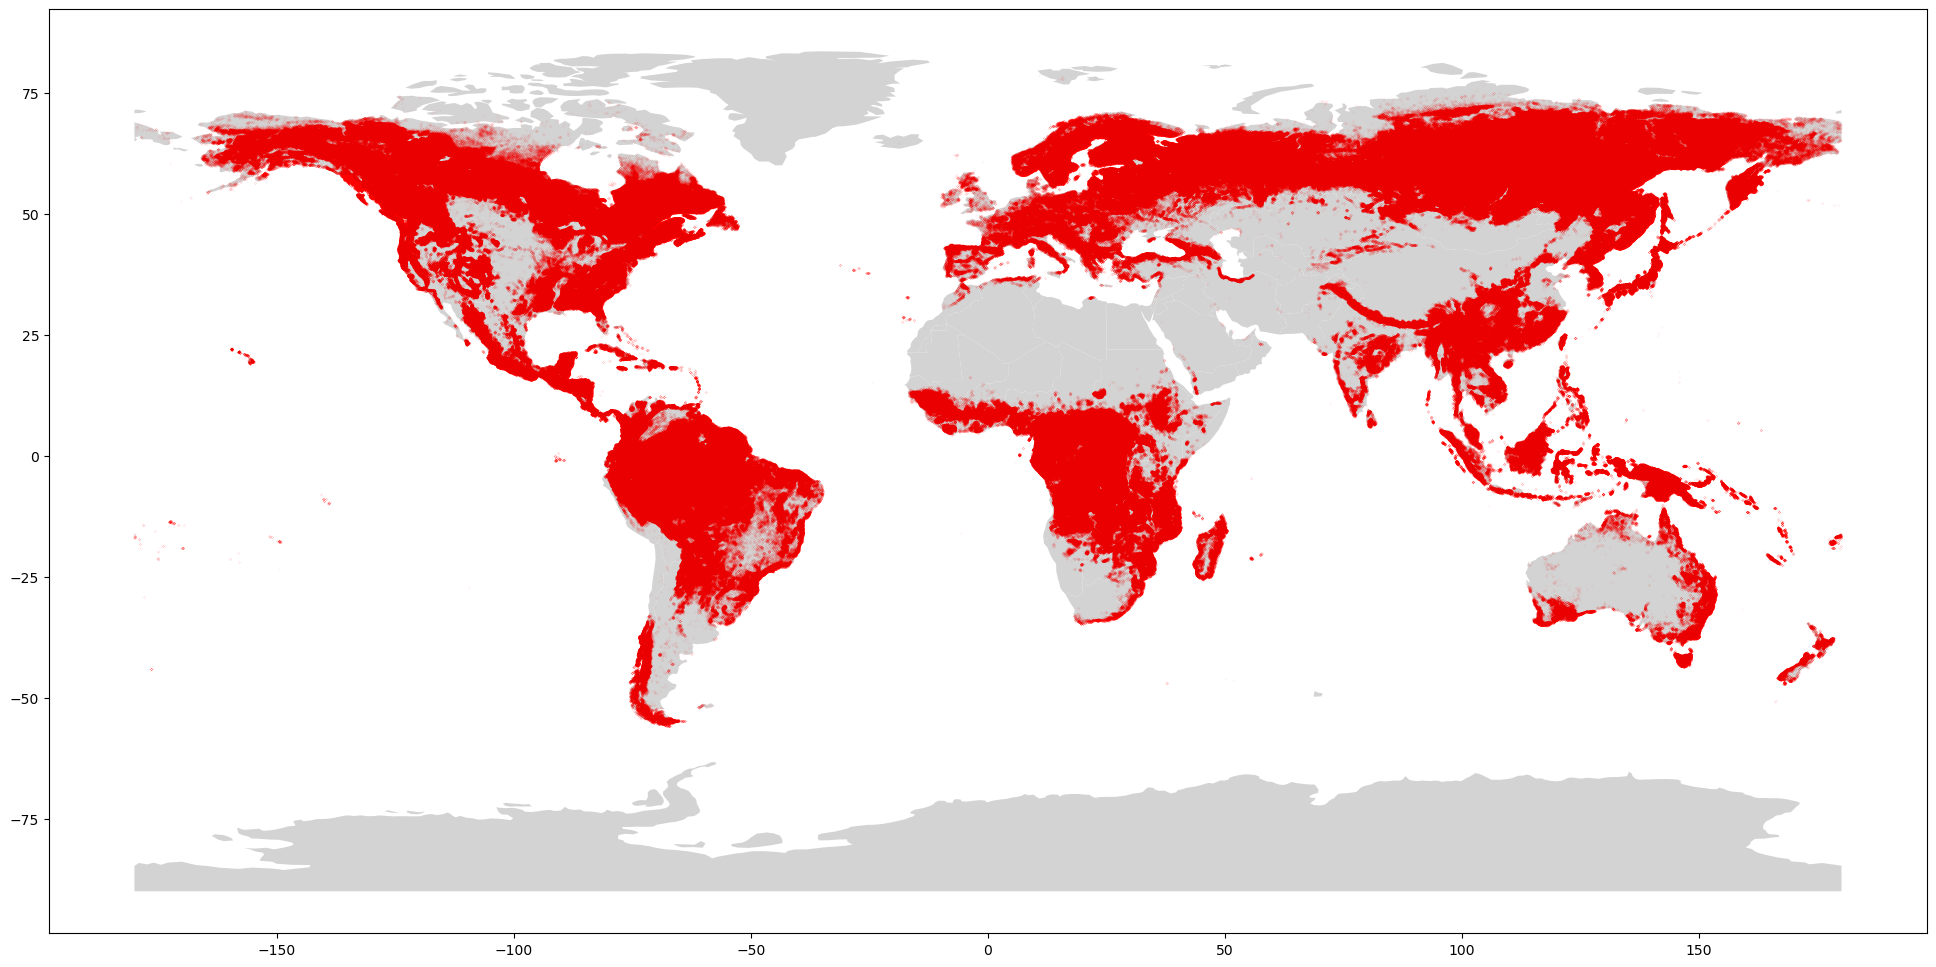

In [19]:
# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(30, 12))
worldmap.plot(color="lightgrey", ax=ax)

#rand_ind = np.random.choice(exp.gdf.index, 100000, replace=False)
exp.gdf.plot(column='value', markersize=0.001, ax=ax, color='red')